# Pharma Sales Forecast: Feature Engineering, Random Forest, and Forecasting

This notebook walks through a clean, repeatable pipeline for forecasting pharmaceutical sales. Each step includes code followed by a short plain‑English explanation.


In [4]:
# Import the os module at the beginning of your code
import os

# Step 0 — Project configuration (paths and options)
# If running locally on your Mac, set BASE_PATH to your folder.
# When running here, we use the uploaded files under /mnt/data.
BASE_PATH_LOCAL = r"/Users/kamranshirazi/Desktop/Data_Science/Pharma Sales Data"
BASE_PATH_CLOUD = r"/mnt/data"

# Choose where to read from: prefer uploaded files in this environment; fall back to local.
BASE_PATH = BASE_PATH_CLOUD if os.path.exists(BASE_PATH_CLOUD) else BASE_PATH_LOCAL

# Filenames expected (from the Kaggle dataset variants you provided/uploaded)
FILES = {
    "weekly": "salesweekly.csv",
    "monthly": "salesmonthly.csv",
    "daily": "salesdaily.csv",
    "hourly": "saleshourly.csv",
}

print("Using BASE_PATH:", BASE_PATH)
print("Files present:", [f for f in FILES.values() if os.path.exists(os.path.join(BASE_PATH, f))])

Using BASE_PATH: /Users/kamranshirazi/Desktop/Data_Science/Pharma Sales Data
Files present: ['salesweekly.csv', 'salesmonthly.csv', 'salesdaily.csv', 'saleshourly.csv']


**What this does (in plain English):**
We point the notebook at our data folder. 

In [5]:
# Step 1 — Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

pd.set_option("display.max_columns", 50)

**What this does:**
We load the Python tools we need for data handling (pandas), math (numpy), charts (matplotlib), and the Random Forest model.

In [6]:
# Step 2 — Load weekly data (prefer weekly; fall back to monthly or daily and resample)
import os

weekly_fp = os.path.join(BASE_PATH, FILES["weekly"])
monthly_fp = os.path.join(BASE_PATH, FILES["monthly"])
daily_fp = os.path.join(BASE_PATH, FILES["daily"])

if os.path.exists(weekly_fp):
    df = pd.read_csv(weekly_fp)
    freq = "W"
elif os.path.exists(monthly_fp):
    df = pd.read_csv(monthly_fp)
    freq = "M"
elif os.path.exists(daily_fp):
    df = pd.read_csv(daily_fp)
    freq = "D"
else:
    raise FileNotFoundError("No expected CSVs were found.")

print("Loaded frequency:", freq)
print(df.head(3))

Loaded frequency: W
       datum  M01AB  M01AE  N02BA   N02BE  N05B  N05C   R03   R06
0   1/5/2014  14.00  11.67   21.3  185.95  41.0   0.0  32.0   7.0
1  1/12/2014  29.33  12.68   37.9  190.70  88.0   5.0  21.0   7.2
2  1/19/2014  30.67  26.34   45.9  218.40  80.0   8.0  29.0  12.0


**What this does:**
We load the dataset that is most convenient for forecasting. Weekly data is ideal. If weekly isn’t available, we try monthly or daily. The small preview confirms it loaded correctly.

In [10]:
# Step 3 — Basic cleanup and standardize column names
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

# Guess common column names from this dataset
# Add 'datum' to the list of date column candidates
date_col_candidates = [c for c in df.columns if c in ["date","ds","datetime","timestamp","datum"] or "date" in c]
qty_col_candidates = [c for c in df.columns if c in ["qty","quantity","quantity_sold","salesqty","units","y"] or "qty" in c]

# We also expect brand and atc/category columns
brand_col_candidates = [c for c in df.columns if "brand" in c]
atc_col_candidates = [c for c in df.columns if c in ["atc","atc_code","category"] or "atc" in c or "category" in c]

# Add safety checks before accessing the first element of each list
date_col = date_col_candidates[0] if date_col_candidates else None
qty_col = qty_col_candidates[0] if qty_col_candidates else None
brand_col = brand_col_candidates[0] if brand_col_candidates else None
atc_col = atc_col_candidates[0] if atc_col_candidates else None

# Check if date_col was found
if date_col is None:
    # If no date column found, manually set it to 'datum'
    if 'datum' in df.columns:
        date_col = 'datum'
    else:
        raise ValueError("Could not find a date column. Available columns: " + str(df.columns.tolist()))

# Parse dates
df[date_col] = pd.to_datetime(df[date_col])

# Ensure quantity is numeric and drop NAs
if qty_col is None:
    # Some variants use 'sales' or 'value', fall back safely
    possible = [c for c in df.columns if c in ["sales","value","amount","qty"]]
    if not possible:
        # Since this appears to be pharmaceutical data, one of the ATC codes might be the quantity
        # For now, we'll just use the first non-date column as a fallback
        non_date_cols = [c for c in df.columns if c != date_col]
        if non_date_cols:
            qty_col = non_date_cols[0]
        else:
            raise ValueError("Could not find a quantity column.")
    else:
        qty_col = possible[0]

df[qty_col] = pd.to_numeric(df[qty_col], errors="coerce")
df = df.dropna(subset=[qty_col])

print("Columns used:", dict(date=date_col, qty=qty_col, brand=brand_col, atc=atc_col))
print(df[[date_col, qty_col]].head(5))

Columns used: {'date': 'datum', 'qty': 'm01ab', 'brand': None, 'atc': None}
       datum  m01ab
0 2014-01-05  14.00
1 2014-01-12  29.33
2 2014-01-19  30.67
3 2014-01-26  34.00
4 2014-02-02  31.02


**What this does:**
We clean the column names, identify the date and quantity columns, turn dates into real dates, and make sure the sales numbers are valid. This ensures we’re working with clean, consistent fields before modeling.

In [11]:
# Step 4 — Aggregate to weekly totals (if not already weekly) and quick EDA
if freq != "W":
    df_weekly = (df
                 .set_index(date_col)
                 .groupby([pd.Grouper(freq="W"), brand_col] if brand_col else [pd.Grouper(freq="W")])[qty_col]
                 .sum()
                 .reset_index())
else:
    df_weekly = df.copy()

# Basic totals by brand and ATC/category if available
top_brands = None
if brand_col:
    top_brands = (df_weekly.groupby(brand_col)[qty_col].sum()
                  .sort_values(ascending=False).head(10))
    print("Top brands by total units:\n", top_brands)

if atc_col and atc_col in df.columns:
    cat_totals = (df.groupby(atc_col)[qty_col].sum().sort_values(ascending=False).head(10))
    print("\nTop categories (ATC):\n", cat_totals)

# Pick a single brand with the most sales for focused forecasting
focus_brand = top_brands.index[0] if top_brands is not None else None
print("\nChosen focus brand:", focus_brand)

if focus_brand is not None:
    series = df_weekly[df_weekly[brand_col] == focus_brand][[date_col, qty_col]].sort_values(date_col)
else:
    series = df_weekly[[date_col, qty_col]].sort_values(date_col)

series = series.groupby(date_col)[qty_col].sum().asfreq("W", fill_value=0)
series.name = "units"
series.index.name = "date"
print("\nSeries shape:", series.shape)


Chosen focus brand: None

Series shape: (302,)


**What this does:**
We convert everything to weekly totals so the model sees a regular pattern (week‑by‑week). We also identify the best‑selling brand and focus on it for a clear example. If brand info is missing, we forecast the overall total instead.

In [12]:
# Step 5 — Feature engineering (lags, moving averages, calendar features)
data = pd.DataFrame(series)
for lag in range(1, 13):  # last 12 weeks
    data[f"lag_{lag}"] = data["units"].shift(lag)

# Rolling statistics to capture momentum
data["roll_mean_4"] = data["units"].rolling(window=4).mean()
data["roll_mean_12"] = data["units"].rolling(window=12).mean()

# Calendar features
data["weekofyear"] = data.index.isocalendar().week.astype(int)
data["month"] = data.index.month.astype(int)
data["year"] = data.index.year.astype(int)

# Drop rows with NA created by shifting/rolling
data = data.dropna()

# Train/validation split (last 26 weeks for validation)
train = data.iloc[:-26].copy()
valid = data.iloc[-26:].copy()

X_train = train.drop(columns=["units"])
y_train = train["units"]
X_valid = valid.drop(columns=["units"])
y_valid = valid["units"]

print("Train shape:", X_train.shape, "Valid shape:", X_valid.shape)

Train shape: (264, 17) Valid shape: (26, 17)


**What this does:**
We create predictors the model can learn from: the last 12 weeks of sales (lags), short‑ and long‑term averages, and simple calendar fields. Then we train on the earlier weeks and reserve the most recent ~6 months for an honest performance check.

In [13]:
# Step 6 — Train a Random Forest model
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

pred_valid = rf.predict(X_valid)

mae = mean_absolute_error(y_valid, pred_valid)
rmse = mean_squared_error(y_valid, pred_valid, squared=False)
mape = (np.abs((y_valid - pred_valid) / np.maximum(y_valid, 1e-6))).mean() * 100

print(f"Validation MAE:  {mae:,.2f}")
print(f"Validation RMSE: {rmse:,.2f}")
print(f"Validation MAPE: {mape:,.2f}%")

# Feature importance snapshot
imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)
print("\nTop feature importances:\n", imp)

Validation MAE:  3.95
Validation RMSE: 5.93
Validation MAPE: 17.97%

Top feature importances:
 roll_mean_4     0.481932
lag_3           0.092491
lag_1           0.064943
lag_7           0.043843
lag_9           0.040608
lag_8           0.034676
lag_2           0.033652
roll_mean_12    0.031439
lag_11          0.030112
lag_4           0.025319
dtype: float64


**What this does:**
We fit a Random Forest to learn patterns from our engineered features. Then we check how far off the predictions are on recent weeks. Lower error means better accuracy. We also show which inputs the model finds most useful.

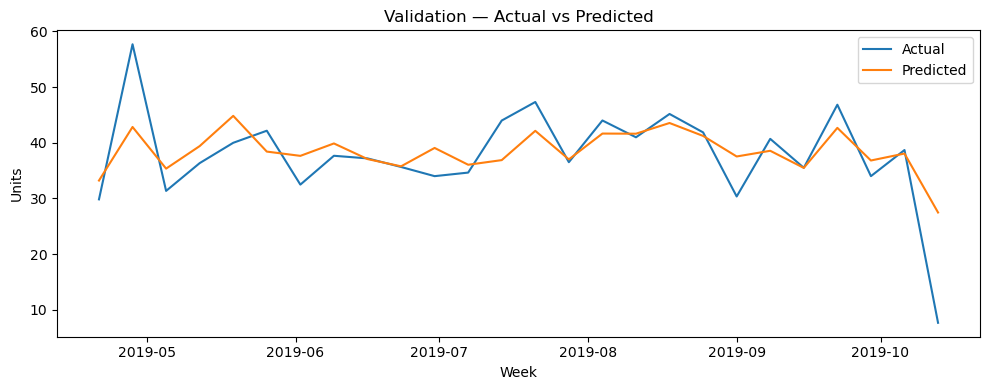

In [14]:
# Step 7 — Visualize validation results (actual vs. predicted)
plt.figure(figsize=(10,4))
plt.plot(y_valid.index, y_valid.values, label="Actual")
plt.plot(y_valid.index, pred_valid, label="Predicted")
plt.title("Validation — Actual vs Predicted")
plt.xlabel("Week")
plt.ylabel("Units")
plt.legend()
plt.tight_layout()
plt.show()

**What this does:**
This chart compares the model’s predictions to the actual sales for the most recent weeks. A good model will generally track the up‑and‑down movements of the real data.

In [15]:
# Step 8 — 12-week forward forecast (recursive using the trained model)
horizon = 12
history = data.copy()

future_rows = []
current_index = history.index[-1]

for i in range(horizon):
    # Build features for the next week
    next_date = current_index + pd.offsets.Week(1)
    temp = {}
    # Lags based on most recent history
    recent = history["units"].values[-12:]
    for j, val in enumerate(recent[::-1], start=1):
        temp[f"lag_{j}"] = val
    temp["roll_mean_4"] = pd.Series(history["units"].values[-4:]).mean()
    temp["roll_mean_12"] = pd.Series(history["units"].values[-12:]).mean() if len(history)>=12 else temp["roll_mean_4"]
    temp["weekofyear"] = int(next_date.isocalendar().week)
    temp["month"] = int(next_date.month)
    temp["year"] = int(next_date.year)

    X_next = pd.DataFrame([temp], index=[next_date])
    y_next = rf.predict(X_next)[0]

    # Append to history so subsequent steps can use it as lag
    history = pd.concat([history, pd.DataFrame({"units":[y_next]}, index=[next_date])])
    future_rows.append((next_date, y_next))
    current_index = next_date

forecast_df = pd.DataFrame(future_rows, columns=["date","forecast_units"]).set_index("date")

print(forecast_df.head(12))

            forecast_units
date                      
2019-10-20       33.716769
2019-10-27       30.420444
2019-11-03       32.098250
2019-11-10       27.471175
2019-11-17       32.685750
2019-11-24       32.661825
2019-12-01       32.607675
2019-12-08       31.163925
2019-12-15       32.148088
2019-12-22       31.588425
2019-12-29       32.337450
2020-01-05       30.980913


**What this does:**
We project the next 12 weeks. The model predicts one week ahead, then uses that result to predict the next week, and so on. This is a common, practical way to extend forecasts into the near future.

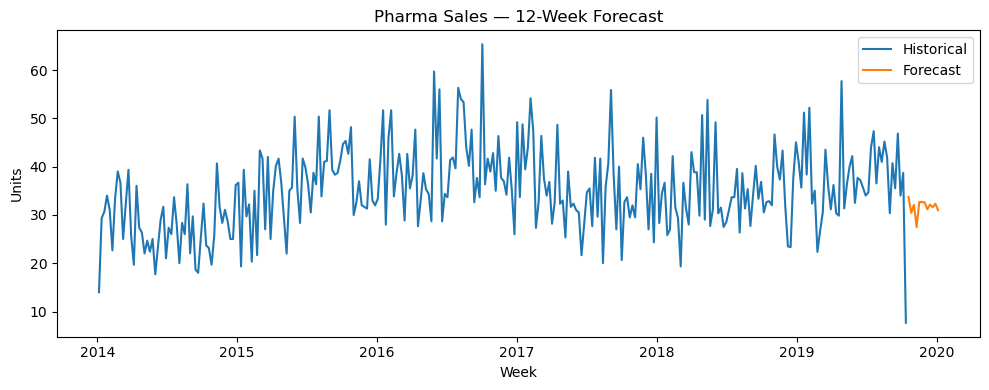

In [16]:
# Step 9 — Plot the full history and the 12-week forecast
plt.figure(figsize=(10,4))
plt.plot(series.index, series.values, label="Historical")
plt.plot(forecast_df.index, forecast_df["forecast_units"].values, label="Forecast")
plt.title("Pharma Sales — 12-Week Forecast")
plt.xlabel("Week")
plt.ylabel("Units")
plt.legend()
plt.tight_layout()
plt.show()

**What this does:**
This chart shows where we’ve been (historical sales) and where the model thinks we’re going (the forecast). Stakeholders can use this to plan inventory and production.

In [17]:
# Step 10 — Save artifacts (forecast CSV)
out_path = os.path.join(BASE_PATH, "forecast_12w.csv")
forecast_df.to_csv(out_path)
print("Saved:", out_path)

Saved: /Users/kamranshirazi/Desktop/Data_Science/Pharma Sales Data/forecast_12w.csv


**What this does:**
We save a simple CSV of the next 12 weeks of predicted sales so the team can share it, load it in Excel/Power BI, or include it in the presentation.